In [1]:
%matplotlib inline

# DISPERSION ANALYSIS II
Author: Jordan Guerra (for Villanova University). May 2024.

This tutorial illustrates the more advanced use of the package *polBpy* for performing the angular dispersion analysis for studying the magnetoturbulent state of gas using dust polarimetric observations. Parameters determined can be used for DCF calculations.

This tutorial uses data from literature listed [here.](https://github.com/jorgueagui/polBpy/blob/9039d4af5d25c49130bf51be7fe0ce363424edcc/refs.md)

**EXAMPLE I**: This example shows how to perform detailed dispersion analysis for a masked region of gas. This analysis involves: i) calculating the autocorrelation function of the polarized flux, and measuring it width as estimation of the cloud's depnth; ii) calcualting a pixel-by-pixel two-point struture function by defining a circular kernel centered at each pixel;, ii) fitting the pixel-by-pixel two-point structure function with the two-scale model of Houde et. al. (2009, 2010) using a MCMC approach and determining the magnetotubrulent parameters. We reproduce here some results from Guerra et. al. (2021), which presents results of the OMC-1 region using multiwavelength observations of SOFIA/HAWC+.

In [2]:
import os
os.chdir(os.path.expanduser("/Users/jguerraa/Desktop/polBpy"))
from polBpy import dispersion, fitting, utils
import numpy as np
import matplotlib.pyplot as plt

In this example we try to reproduce resukts from Guerra et. al. (2021). Specifically, reproducing the plots in Figure 3, which utilizes the 214-$\mu$m data from HAWC+. First, we calculate the $\Delta^{\prime}$ through the autocorrelation function. 

In [3]:
from astropy.io import fits
file = "/Users/jguerraa/Desktop/polBpy/tutorials/PolBpy_Tutorial_IV_data.fits"
data = fits.open(file)
print(data.info())

Filename: /Users/jguerraa/Desktop/polBpy/tutorials/PolBpy_Tutorial_IV_data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU     597   (102, 114)   float64   
  1  ERROR I       1 ImageHDU        27   (102, 114)   float64   
  2  STOKES Q      1 ImageHDU        18   (102, 114)   float64   
  3  ERROR Q       1 ImageHDU        18   (102, 114)   float64   
  4  STOKES U      1 ImageHDU        18   (102, 114)   float64   
  5  ERROR U       1 ImageHDU        18   (102, 114)   float64   
  6  IMAGE MASK    1 ImageHDU        27   (102, 114)   float64   
  7  PERCENT POL    1 ImageHDU        18   (102, 114)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        18   (102, 114)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        18   (102, 114)   float64   
 10  POL ANGLE     1 ImageHDU        18   (102, 114)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        18   (102, 114)   float64   
 12  ERROR POL ANGLE    1 ImageHDU       

First, we exclude the points with p/p_err > 3.0
by creating a mask,

In [4]:
p_flux = data['DEBIASED POL FLUX'].data # 
p_flux_err = data['ERROR POL FLUX'].data #
pixel_size = data[0].header['CDELT2']*3600 #in arcsec
# Find the points
m = np.where(p_flux/p_flux_err > 3.0)
# Create the mask
mask = np.full_like(p_flux,0.0)
mask[m] = 1.0

Now we call the autocorrelation function (for further details on this function see Tutorial III),

In [5]:
res = dispersion.autocorrelation(p_flux,p_flux_err,pixsize=pixel_size,mask=mask,plots=False,hwhm=True)

And print the $\Delta^{\prime}$ in the (multiple of) units of pixel_size

In [6]:
print("Delta' = %2.2f +/- %2.2f [arcmin]"%(res[0],res[1]))

Delta' = 1.55 +/- 0.12 [arcmin]


In order to calculate the map of dispersion functions, we need to define the relevant variables

In [7]:
angles = data['ROTATED POL ANGLE'].data # km/s
angles_err = data['ERROR POL ANGLE'].data # km/s
beam_s = 4*pixel_size # FWHM value of the beam
win_s = 9 # pixel

In [8]:
res1 = dispersion.dispersion_function_map(angles,angles_err,pixel_size,mask=mask,beam=beam_s,w=win_s,verb=False)

Analysis window size =  19 x 19
Skipping Pixel = 9 9
Skipping Pixel = 9 10
Skipping Pixel = 9 11
Skipping Pixel = 9 12
Skipping Pixel = 9 13
Skipping Pixel = 9 14
Skipping Pixel = 9 15
Skipping Pixel = 9 16
Skipping Pixel = 9 17
Skipping Pixel = 9 18
Skipping Pixel = 9 19
Skipping Pixel = 9 20
Skipping Pixel = 9 21
Skipping Pixel = 9 22
Skipping Pixel = 9 23
Skipping Pixel = 9 24
Skipping Pixel = 9 25
Skipping Pixel = 9 26
Skipping Pixel = 9 27
Skipping Pixel = 9 28
Skipping Pixel = 9 29
Skipping Pixel = 9 30
Skipping Pixel = 9 31
Skipping Pixel = 9 32
Skipping Pixel = 9 33
Skipping Pixel = 9 34
Skipping Pixel = 9 35
Skipping Pixel = 9 43
Skipping Pixel = 9 44
Skipping Pixel = 9 45
Skipping Pixel = 9 56
Skipping Pixel = 9 57


/Users/jguerraa/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jguerraa/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jguerraa/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jguerraa/Desktop/polBpy/polBpy/utils.py:95: RuntimeWarning: Mean of empty slice
  rms = np.sqrt(np.nanmean(vec**2))
/Users/jguerraa/Desktop/polBpy/polBpy/dispersion.py:141: RuntimeWarning: invalid value encountered in sqrt
  errors_c[i]= np.sqrt( (sinDphisum[i]**2)*sigma2sum[i] + (sinDphisum[i]**2)*Dphisum[i] + \
/Users/jguerraa/Desktop/polBpy/polBpy/utils.py:99: RuntimeWarning: invalid value enc

Skipping Pixel = 9 89
Skipping Pixel = 9 90
Skipping Pixel = 9 91
Skipping Pixel = 9 92
Skipping Pixel = 10 9
Skipping Pixel = 10 10
Skipping Pixel = 10 11
Skipping Pixel = 10 12
Skipping Pixel = 10 13
Skipping Pixel = 10 14
Skipping Pixel = 10 15
Skipping Pixel = 10 16
Skipping Pixel = 10 17
Skipping Pixel = 10 18
Skipping Pixel = 10 19
Skipping Pixel = 10 20
Skipping Pixel = 10 21
Skipping Pixel = 10 22
Skipping Pixel = 10 23
Skipping Pixel = 10 24
Skipping Pixel = 10 25
Skipping Pixel = 10 31
Skipping Pixel = 10 32
Skipping Pixel = 10 33
Skipping Pixel = 10 34
Skipping Pixel = 10 35
Skipping Pixel = 10 44
Skipping Pixel = 10 45
Skipping Pixel = 10 56
Skipping Pixel = 10 57
Skipping Pixel = 10 78
Skipping Pixel = 10 89
Skipping Pixel = 10 90
Skipping Pixel = 10 91
Skipping Pixel = 10 92
Skipping Pixel = 11 9
Skipping Pixel = 11 10
Skipping Pixel = 11 11
Skipping Pixel = 11 12
Skipping Pixel = 11 13
Skipping Pixel = 11 14
Skipping Pixel = 11 15
Skipping Pixel = 11 16
Skipping Pixel = 

Skipping Pixel = 33 78
Skipping Pixel = 33 79
Skipping Pixel = 33 90
Skipping Pixel = 33 91
Skipping Pixel = 33 92
Skipping Pixel = 34 9
Skipping Pixel = 34 12
Skipping Pixel = 34 13
Skipping Pixel = 34 91
Skipping Pixel = 34 92
Skipping Pixel = 35 90
Skipping Pixel = 35 91
Skipping Pixel = 35 92
Skipping Pixel = 36 90
Skipping Pixel = 36 91
Skipping Pixel = 36 92
Skipping Pixel = 37 92
Skipping Pixel = 40 92
Skipping Pixel = 41 89
Skipping Pixel = 41 90
Skipping Pixel = 41 91
Skipping Pixel = 41 92
Skipping Pixel = 42 89
Skipping Pixel = 42 90
Skipping Pixel = 42 91
Skipping Pixel = 42 92
Skipping Pixel = 43 81
Skipping Pixel = 43 89
Skipping Pixel = 43 90
Skipping Pixel = 43 91
Skipping Pixel = 43 92
Skipping Pixel = 44 79
Skipping Pixel = 44 80
Skipping Pixel = 44 81
Skipping Pixel = 44 82
Skipping Pixel = 44 91
Skipping Pixel = 44 92
Skipping Pixel = 45 91
Skipping Pixel = 45 92
Skipping Pixel = 46 91
Skipping Pixel = 46 92
Skipping Pixel = 47 90
Skipping Pixel = 52 84
Skipping Pix

Skipping Pixel = 103 57
Skipping Pixel = 103 58
Skipping Pixel = 103 59
Skipping Pixel = 103 60
Skipping Pixel = 103 66
Skipping Pixel = 103 67
Skipping Pixel = 103 68
Skipping Pixel = 103 69
Skipping Pixel = 103 70
Skipping Pixel = 103 71
Skipping Pixel = 103 72
Skipping Pixel = 103 73
Skipping Pixel = 103 74
Skipping Pixel = 103 77
Skipping Pixel = 103 78
Skipping Pixel = 103 79
Skipping Pixel = 103 80
Skipping Pixel = 103 81
Skipping Pixel = 103 82
Skipping Pixel = 103 83
Skipping Pixel = 103 84
Skipping Pixel = 103 85
Skipping Pixel = 103 86
Skipping Pixel = 103 87
Skipping Pixel = 103 88
Skipping Pixel = 103 89
Skipping Pixel = 103 90
Skipping Pixel = 103 91
Skipping Pixel = 103 92
Skipping Pixel = 104 9
Skipping Pixel = 104 10
Skipping Pixel = 104 11
Skipping Pixel = 104 12
Skipping Pixel = 104 13
Skipping Pixel = 104 14
Skipping Pixel = 104 15
Skipping Pixel = 104 57
Skipping Pixel = 104 58
Skipping Pixel = 104 59
Skipping Pixel = 104 60
Skipping Pixel = 104 61
Skipping Pixel = 

For sanity check, let us visualize one dispersion function,

Text(0, 0.5, '$1-\\langle \\cos(\\Delta\\phi)\\rangle$')

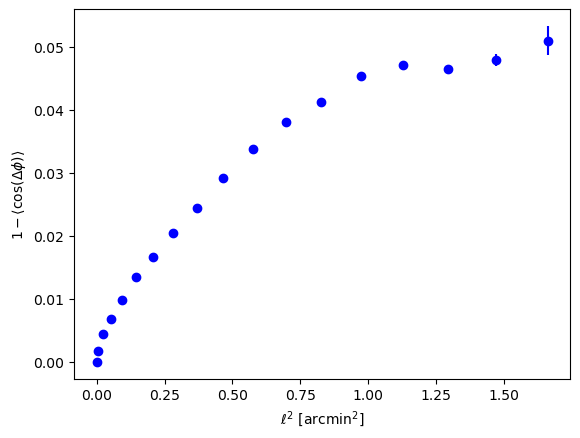

In [42]:
epix = (50,50)
lvec = res1[0][epix]/3600.
disp_f = res1[1][epix]
disp_f_err = res1[2][epix]
plt.errorbar(lvec,disp_f,yerr=disp_f_err,fmt='bo')
plt.xlabel(r'$\ell^{2}$ [arcmin$^{2}$]')
plt.ylabel(r'$1-\langle \cos(\Delta\phi)\rangle$')

And now we fit all the dispersion functions by MCMC and find the maps of paremeters,

In [10]:
m_lvec = res1[0][40:60,40:60,:] # in arcsec^2
m_disp_f = res1[1][40:60,40:60,:]
m_disp_f_err = res1[2][40:60,40:60,:]
res2 = fitting.mcmc_fit_map(disp_f,lvec,disp_f_err,win_s,pixel_size,beam=beam_s,a2=1.0E-3,delta=30.,f=100.,num=200,
                            verb=False,n_cores=10)

Running MCMC fitting in 10 cores


First, let us inspect the fit for the dispersion function plotted avobe,

In [45]:
l = np.arange(0,10000) # define some values of \ell^2 in arcsec for the model
# Choose the same pixel example
nepix = (10,10)
f = fitting.model_funct(l,res2['a'][nepix],res2['d'][nepix],(res2['f'][nepix]),beam=beam_s)

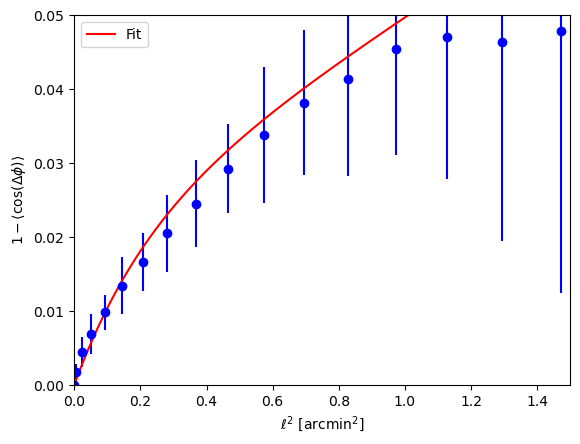

In [44]:
lvec = res1[0][epix]/3600.
disp_f = res1[1][epix]
disp_f_err = res1[2][epix]
plt.errorbar(lvec,disp_f,yerr=res2['chi'][10,10]*disp_f_err,fmt='bo')
plt.xlabel(r'$\ell^{2}$ [arcmin$^{2}$]')
plt.ylabel(r'$1-\langle \cos(\Delta\phi)\rangle$')
plt.plot(l/3600., f,c='red',label='Fit')
plt.ylim([0.,0.05])
plt.xlim([0.,1.5])
plt.legend()

Inspect the values,

In [46]:
a2 = res2['a'][nepix]*3600.*1000 # Units of 10^{-3} arcmin^{-2}
print("a_2 = %2.3E [arcmin^-2]"%a2)

a_2 = 2.914E+01 [arcmin^-2]


In [47]:
delta = res2['d'][nepix]
print("delta = %2.2f [arcsec]"%delta)

delta = 16.87 [arcsec]


In [48]:
Delta_p = res[0]*60.
ratio = Delta_p/res2['f'][nepix]
print("ratio = %2.2f"%ratio)

ratio = 0.07


We can now visualize the maps of parameters calculated,

Text(0.5, 1.0, '$ratio$')

<Figure size 2000x500 with 0 Axes>

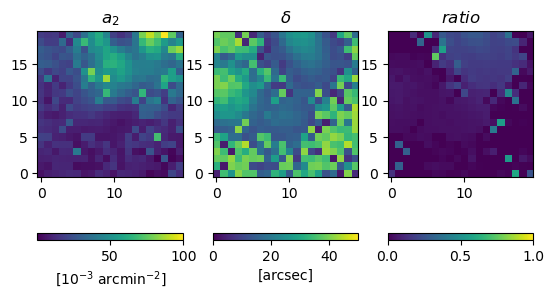

In [49]:
a2_map = res2['a']*3600*1000 # Units of 10^{-3} arcmin^{-2}
delta_map = res2['d'] # arcsec
ratio_map = Delta_p/res2['f']
plt.figure(figsize=(20,5))
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1)
g = ax1.imshow(a2_map,origin='lower',vmin=1.,vmax=100.)
plt.colorbar(g,ax=ax1,orientation='horizontal',label=r'[10$^{-3}$ arcmin$^{-2}$]')
ax1.set_title(r'$a_{2}$')
g = ax2.imshow(delta_map,origin='lower',vmin=0.,vmax=50.)
plt.colorbar(g,ax=ax2,orientation='horizontal', label='[arcsec]')
ax2.set_title(r'$\delta$')
g = ax3.imshow(ratio_map,origin='lower',vmin=0.,vmax=1.)
plt.colorbar(g,ax=ax3,orientation='horizontal',label='')
ax3.set_title(r'$ratio$')

The MCMC solver sometimes provides solutions for pixels that are out of statistics for their inmediate region. So, we "clean" the maps by comparing each pixel value with the median in a 3x3 kernel and interpolating if it's greater than 3 the sigma,

In [50]:
c_a2_map = utils.clean_map(a2_map,sigma=2)
c_delta_map = utils.clean_map(delta_map,sigma=2)
c_ratio_map = utils.clean_map(ratio_map,sigma=2)

Text(0.5, 0.98, 'Clean Maps')

<Figure size 2000x500 with 0 Axes>

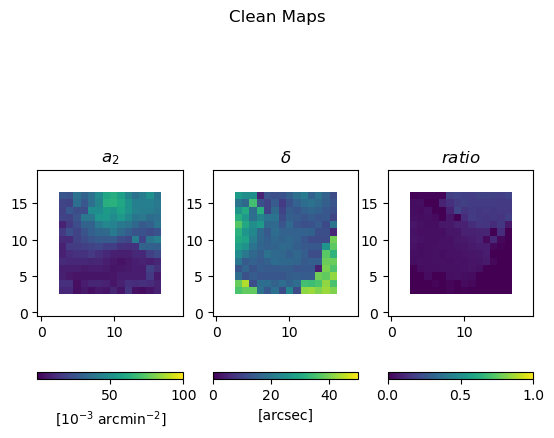

In [51]:
plt.figure(figsize=(20,5))
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1)
g = ax1.imshow(c_a2_map,origin='lower',vmin=1.,vmax=100.)
plt.colorbar(g,ax=ax1,orientation='horizontal',label=r'[10$^{-3}$ arcmin$^{-2}$]')
ax1.set_title(r'$a_{2}$')
g = ax2.imshow(c_delta_map,origin='lower',vmin=0.,vmax=50.)
plt.colorbar(g,ax=ax2,orientation='horizontal', label='[arcsec]')
ax2.set_title(r'$\delta$')
g = ax3.imshow(c_ratio_map,origin='lower',vmin=0.,vmax=1.)
plt.colorbar(g,ax=ax3,orientation='horizontal',label='')
ax3.set_title(r'$ratio$')
fig.suptitle('Clean Maps')

We save these maps into a pickle file for using in Tutorial V where we will use one of them for computing a map of Bpos through DCF approximations.

In [52]:
res3 = {'a2_map':c_a2_map,'delta_map':c_delta_map,'ratio_map':c_ratio_map}
import pickle
pickle.dump(res3,open('disp_analysis_maps.pk',"wb"))